In [1]:
# ------------ System imports ------------
import os
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

import os 
import sys
import datetime
import time
import argparse

# ------------ Scientific imports ------------
import pandas as pd
import seaborn as sns
import numpy as np

import sklearn as skl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense


from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
from sklearn.feature_selection import SelectKBest,f_classif

In [89]:
# ------------ Stacking Framwework ------------
#Stacking method is inspired by the following resource: https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/


def stacking_pipeline(X_test, y_test,
	models = [],
	num_hidden_layers=3, num_nodes=10,
	hidden_act = 'relu', 
	model_loss = 'categorical_crossentropy'):

	#~~~~~~ PREPARE MODELS ~~~~~~~#
	for i in range(len(models)):
		model = models[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i) + '_' + layer.name

	# ~~~~~ SETUP STACKING ~~~~~~#
	# define multi-headed input
	ensemble_visible = [model.input for model in models]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in models]
	merge = concatenate(ensemble_outputs)

	# Setup hidden layers
	for l in range(num_hidden_layers):
		if l == 0:
			layer = Dense(num_nodes, activation=hidden_act)(merge)
		else:
			layer = Dense(num_nodes, activation=hidden_act)(layer)

	# Setup output layers and finalize model
	output = Dense(2, activation='softplus')(layer)
	model = Model(inputs=ensemble_visible, outputs=output)

	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph_sim_experiment-one.png')

	# compile
	opt = tf.keras.optimizers.RMSprop(lr=0.01,clipnorm=0.5)
	model.compile(loss=model_loss, optimizer=opt, metrics='accuracy')

	# prepare input data
	X = [X_test for _ in range(len(model.input))]
	
	# encode output data
	y_test_enc = to_categorical(y_test)
	
	# fit model
	model.fit(X, y_test_enc, epochs=100, verbose=0)
	
	# make prediction
	pred = model.predict(X, batch_size=32, verbose=0)
	#print(pred)
	return pred

In [60]:
df = pd.read_csv('../../experiments/Lauren/submodel_stuff_2c_large_2f.csv')
df['Model ID'].add(1)

0        2
1        3
2        4
3        5
4        6
      ... 
373    375
374    376
375    377
376    378
377    379
Name: Model ID, Length: 378, dtype: int64

In [138]:
#load data for specific experiment

X_test = pd.read_csv('../../data/simulated/simulated_raw/X_test_2c_large_2f.csv')
y_test = pd.read_csv('../../data/simulated/simulated_raw/y_test_2c_large_2f.csv')

#Look at the saved accuracies of the models to use 


df = pd.read_csv('../../data/simulated/submodel_stuff_2c_large_2f.csv')
#high performers
df['Model ID'].add(1)
ids_high = (df.loc[df['Model Accuracy'] >= 0.8]['Model ID'])

#average performance of high-performers:

#low performers
ids_low = df.loc[df['Model Accuracy'] <= 0.5]['Model ID']

array([[<AxesSubplot:title={'center':'Model Accuracy'}>]], dtype=object)

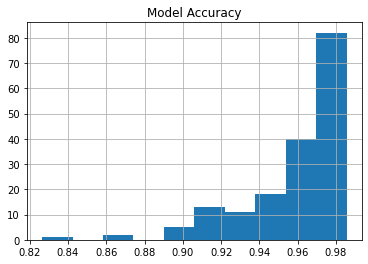

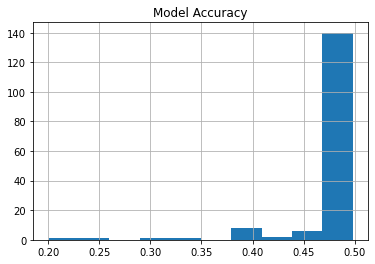

In [141]:
#check out the distribution of high-peformers

df.loc[df['Model Accuracy'] >= 0.8].hist('Model Accuracy')

#check out the distribution of low-performers
df.loc[df['Model Accuracy'] <= 0.5].hist('Model Accuracy')

In [129]:
#finds the proper models to use for experiment

models_high = []
models_low = []
sim_ids = ['2cl2f','2cl8f','2cs2f','2cs8f','3cl2f','3cs2f','3cl8f','3cs8f']
for x in os.listdir('../../data/simulated/simulated_models/'):
    try:
        if x.split('_')[-1][:-3] == sim_ids[0]:
            if int(x.split('_')[1]) in ids_high:
                models_high.append(x)
            elif int(x.split('_')[1]) in ids_low:
                models_low.append(x)
    except:
        pass
print(len(models_high))
print(len(models_low))

172
160


In [130]:
#actually load models for each experiment to use for stacking. 172 well-performing models, 160 poor-performing models

good_models = [load_model('../../data/simulated/simulated_models/{}'.format(x)) for x in models_high]
bad_models = [load_model('../../data/simulated/simulated_models/{}'.format(x)) for x in models_low]

In [90]:

#create stacking model for sub-models. First, let's just check for one general stacking model, see if the accuracies are any better.

num_layers = []
num_nodes = []
hidden_acts = []
losses = []
accuracies = []


import warnings
warnings.filterwarnings('ignore')

for num_layer in [5]:
    for num_node in [10]:
        for hidden_act in ['relu']:
            for loss in ['categorical_crossentropy']:
                yhat = stacking_pipeline(
                    X_test=X_test, y_test=y_test,
                    models=good_models,
                    num_hidden_layers=num_layer, num_nodes=num_node,
                    hidden_act=hidden_act, 
                    model_loss=loss
                )
                yhat = argmax(yhat, axis=1)
                acc = accuracy_score(y_test, yhat)

                print('Accuracy: {:.6f}'.format(acc))

                num_layers.append(num_layer)
                num_nodes.append(num_node)
                hidden_acts.append(hidden_act)
                losses.append(loss)
                accuracies.append(acc)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.429247 to fit

Accuracy: 0.979933


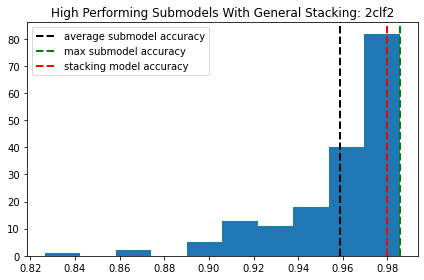

In [142]:
plt.figure()
grab = df.loc[df['Model Accuracy'] >= 0.8]
grab = grab['Model Accuracy']
plt.hist(grab)
plt.axvline(x=np.average(grab), color='k', linestyle='dashed', linewidth=2, label='average submodel accuracy')
plt.axvline(x=np.max(grab), color='g', linestyle='dashed', linewidth=2, label='max submodel accuracy')
plt.axvline(x=0.979933, color='r', linestyle='dashed', linewidth=2, label='stacking model accuracy')
plt.title('High Performing Submodels With General Stacking: 2clf2')
plt.legend()
plt.tight_layout()
plt.savefig('../../results/2clf2_exp1_1')

In [91]:
dicty = {
    "Layers": num_layers,
    "Nodes": num_nodes,
    "Hidden Activation": hidden_acts,
    "Model Loss": losses,
    "Accuracy": accuracies
}

dfy = pd.DataFrame(dicty)
dfy.to_csv('sim_2cl2f_exp1_1.csv')

In [131]:
#look at for badly performing models

num_layers = []
num_nodes = []
hidden_acts = []
losses = []
accuracies = []


import warnings
warnings.filterwarnings('ignore')

for num_layer in [5]:
    for num_node in [10]:
        for hidden_act in ['relu']:
            for loss in ['categorical_crossentropy']:
                yhat = stacking_pipeline(
                    X_test=X_test, y_test=y_test,
                    models=bad_models,
                    num_hidden_layers=num_layer, num_nodes=num_node,
                    hidden_act=hidden_act, 
                    model_loss=loss
                )
                yhat = argmax(yhat, axis=1)
                acc = accuracy_score(y_test, yhat)

                print('Accuracy: {:.6f}'.format(acc))

                num_layers.append(num_layer)
                num_nodes.append(num_node)
                hidden_acts.append(hidden_act)
                losses.append(loss)
                accuracies.append(acc)
                print(acc)





dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.463583 to fit

Accuracy: 0.983278
0.9832775919732442


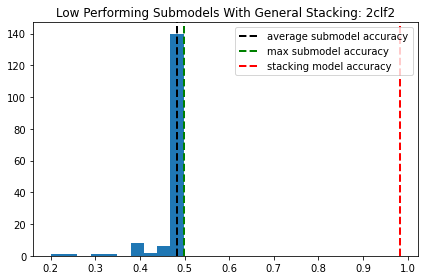

In [143]:
plt.figure()
grab = df.loc[df['Model Accuracy'] <= 0.5]
grab = grab['Model Accuracy']
plt.hist(grab)
plt.axvline(x=np.average(grab), color='k', linestyle='dashed', linewidth=2, label='average submodel accuracy')
plt.axvline(x=np.max(grab), color='g', linestyle='dashed', linewidth=2, label='max submodel accuracy')
plt.axvline(x=0.983278, color='r', linestyle='dashed', linewidth=2, label='stacking model accuracy')
plt.title('Low Performing Submodels With General Stacking: 2clf2')
plt.legend()
plt.tight_layout()
plt.savefig('../../results/2clf2_exp1_2')